In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import warnings
from scipy.interpolate import CubicSpline

In [2]:
warnings.filterwarnings("ignore")

In [3]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Ano')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [4]:
def centered_moving_average(column, window_action, window_size):
    start_index, end_index = window_action
    data = column.to_numpy()

    data_length = len(data)

    for i in range(start_index, end_index + 1):
        if not np.isnan(data[i]):
            init = data[i]
            start = max(0, i - window_size)
            end = min(data_length, i + window_size + 1)
            window = data[start:end]
            valid_values = [value for value in window if not pd.isna(value)]
            if len(valid_values) > 0:
                data[i] = np.mean(valid_values)

    modified_column = pd.Series(data, name=column.name)

    return modified_column

In [6]:
# Cubic spline Interpolation data inputation method
def four_ends_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        for i in range(4):
            column = first_filler(column, i, len(column) - 1 - i)
            column = last_filler(column, i, len(column) - 1 - i)
    return column

def four_ends_linear_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        size = len(column) - 1
        column = first_filler(column, 0, size)
        column = last_filler(column, 0, size)
        for i in range(1, 4):
            value = column.at[i]
            if (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_first = i - 1
                end_first = next_valid_index(column, i)
                linear_a = (column.at[end_first] - column.at[i - 1])/(end_first - start_first)
                linear_b = column.at[start_first] - linear_a*start_first
                column.at[i] = linear_a*i + linear_b
            x = size - 4 + i
            value = column.at[x]
            if (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_last = prev_valid_index(column, x)
                end_last = next_valid_index(column, x)
                gap = list(range(start_last + 1, end_last))
                linear_a = (column.at[end_last] - column.at[start_last])/(end_last - start_last)
                linear_b = column.at[start_last] - linear_a*start_last
                column.at[x] = linear_a*x + linear_b
    return column

def first_filler(column, init, end):
    if pd.isnull(column.at[init]) or np.isnan(column.at[init]):
        first_valid_index = 0
        while first_valid_index <= end and (pd.isnull(column.at[first_valid_index]) or 
                                             np.isnan(column.at[first_valid_index])):
            first_valid_index += 1
        if first_valid_index > end:
            column.at[init] = 0.0
        else:
            column.at[init] = column.at[first_valid_index]
    return column
    
def last_filler(column, init, end):
    if pd.isnull(column.at[end]) or np.isnan(column.at[end]):
        last_valid_index = len(column) -1
        while last_valid_index >= init and (pd.isnull(column.at[last_valid_index]) or 
                                         np.isnan(column.at[last_valid_index])):
            last_valid_index -= 1
        if last_valid_index < init:
            column.at[end] = 0.0
        else:
            column.at[end] = column.at[last_valid_index]
    return column
  
def neareast_four_indexes(column, start, end):
    return prev_four_valid_indexes(column, start) + next_four_valid_indexes(column, end)

def prev_four_valid_indexes(column, pos):
    prev_index = pos
    index_prev_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_prev_list[3 - i] = prev_index
            prev_index -= 1
            while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
                prev_index -= 1
    return index_prev_list  

def next_four_valid_indexes(column, pos):
    next_index = pos
    index_next_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_next_list[i] = next_index
            next_index += 1
            while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
                next_index += 1
    return index_next_list  

def prev_valid_index(column, pos):
    prev_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        prev_index -= 1
        while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
            prev_index -= 1
    return prev_index  

def next_valid_index(column, pos):
    next_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        next_index += 1
        while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
            next_index += 1
    return next_index

def interpolating_polynomial(nearest_indexes, nearest_values):
    coeffs = np.polyfit(nearest_indexes, nearest_values, 3)
    return np.poly1d(coeffs)

def polynomial_filler(column):
    size = len(column) -1
    if column.isnull().any() and column.isna().any():
        for i, value in enumerate(column):
            if (i > 3 and i < size - 3) and (pd.isnull(value) or np.isnan(value) or (value == '')):
                nearest_values = []
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                nearest_indexes = neareast_four_indexes(column, start, end)
                for index in nearest_indexes:
                    nearest_values.append(column.at[index])
                polynomial = interpolating_polynomial(nearest_indexes, nearest_values)
                for x in gap:
                    column.at[x] = polynomial(x)
                plot_polynomial(polynomial, nearest_indexes[0], nearest_indexes[len(nearest_indexes) - 1], 50, gap, nearest_indexes, column.name)
    return column

def plot_polynomial(polynomial, start, end, precision, interpolated_list, nearest_indexes, column_name):
    x = np.linspace(start, end, precision)
    y = polynomial(x)

    plt.figure()

    plt.plot(x, y)

    interpolated_x = interpolated_list  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='red')
    interpolated_x = nearest_indexes  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='green')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(column_name)

    plt.show()
    
def replace_negative_with_float_zeros(x):
    return 0.0 if x < 0 else x

In [7]:
def read_csv_replace_missing_by_polynomial(file_path, skiped_rows, skiped_columns):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path, skiprows=skiped_rows)
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > skiped_columns:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = four_ends_linear_filler(df[col])
                df[col] = centered_moving_average(df[col], (0, len(df[col]) - 1), 24) #2 anos
                df[col] = polynomial_filler(df[col])
            i += 1
        return df

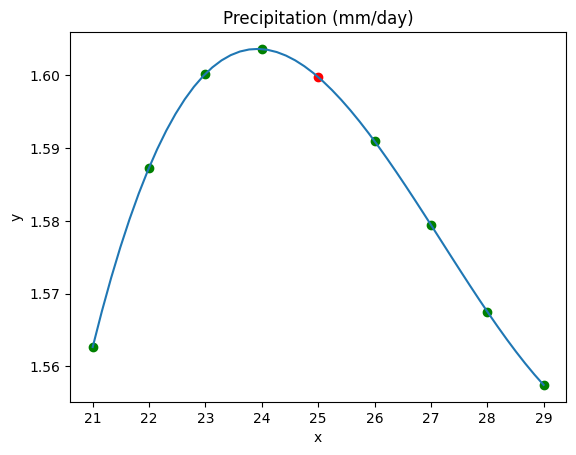

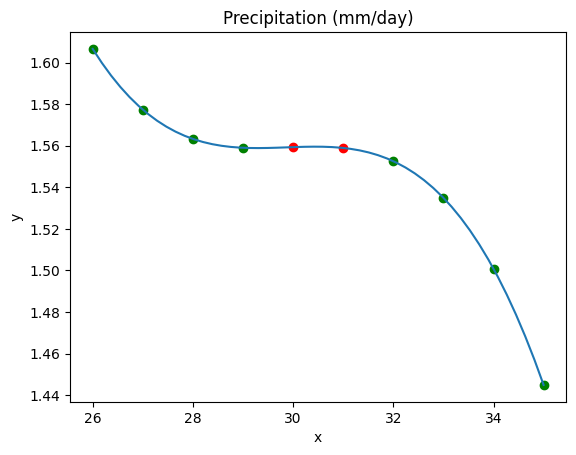

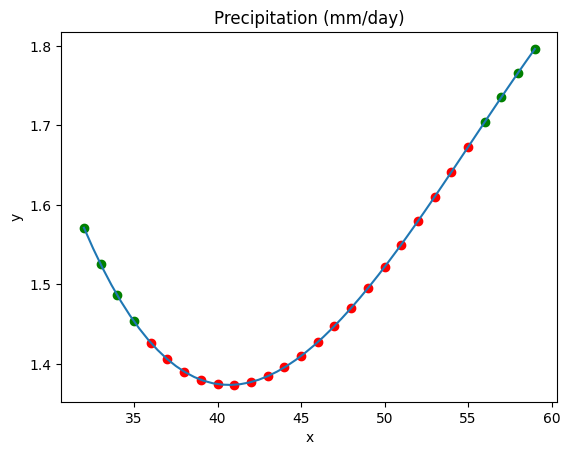

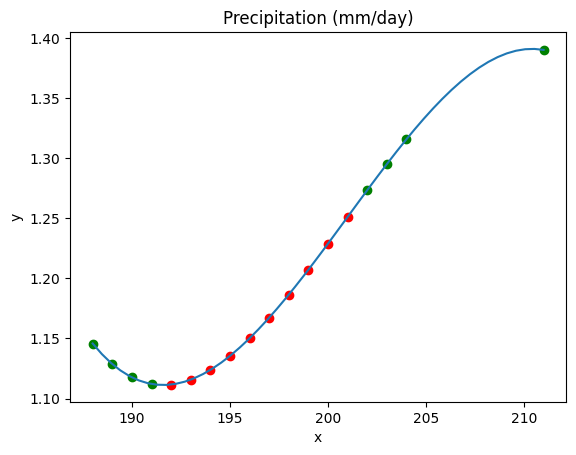

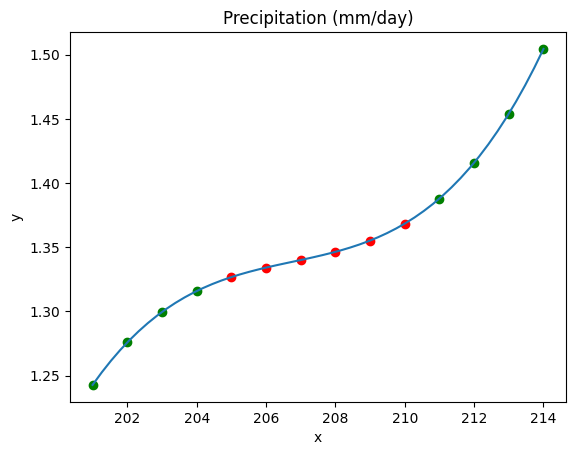

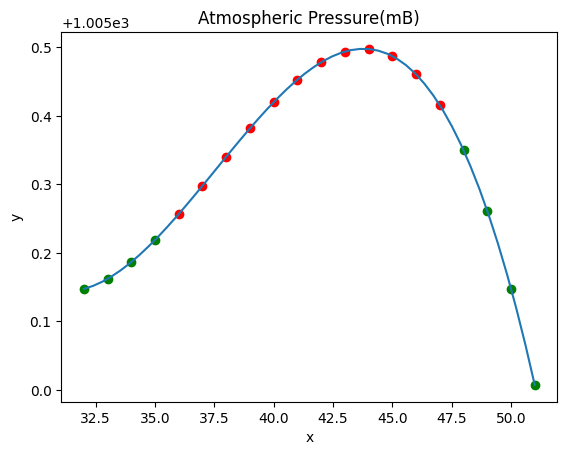

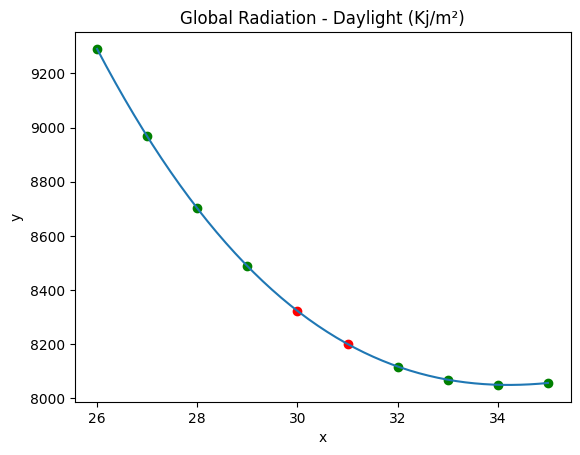

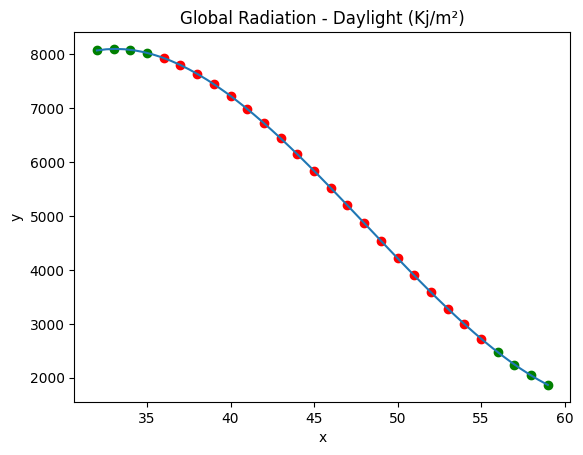

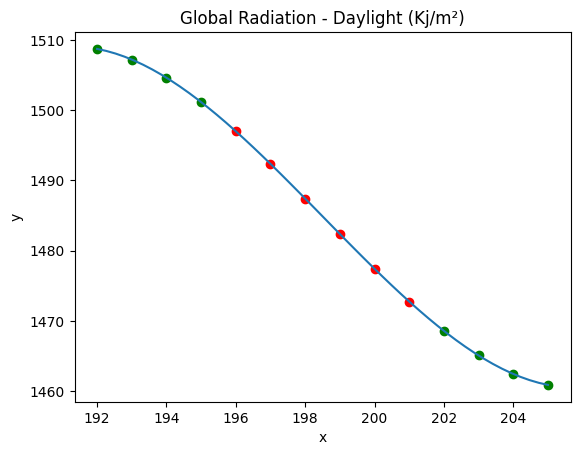

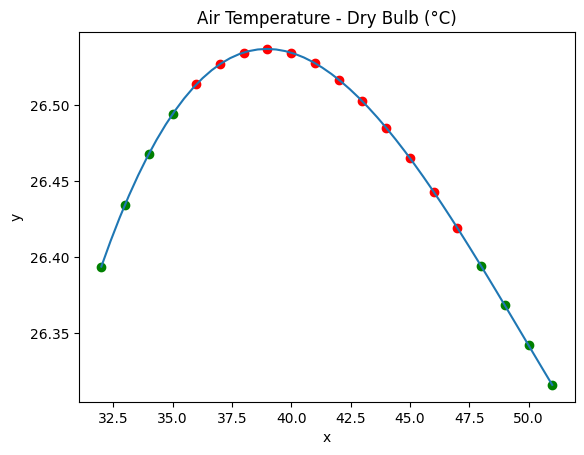

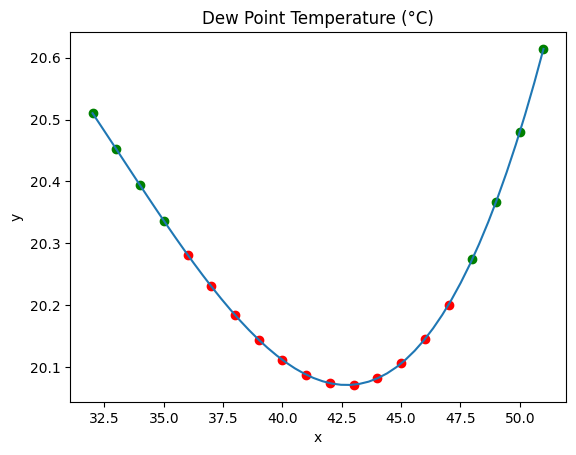

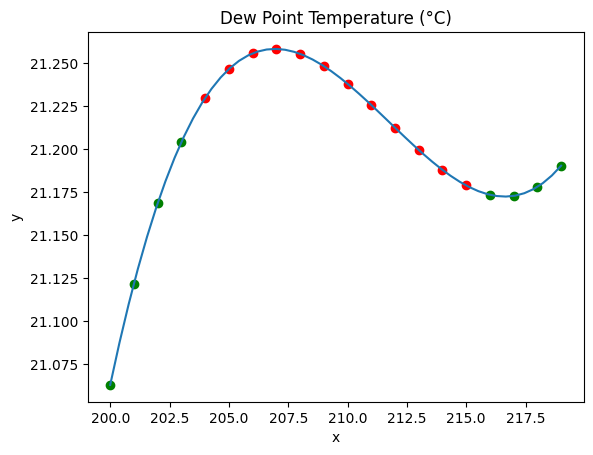

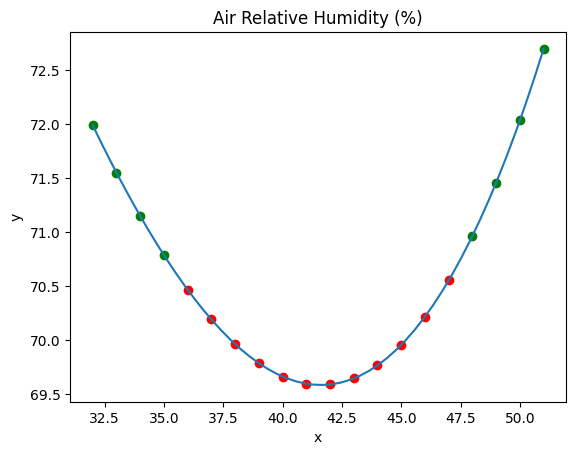

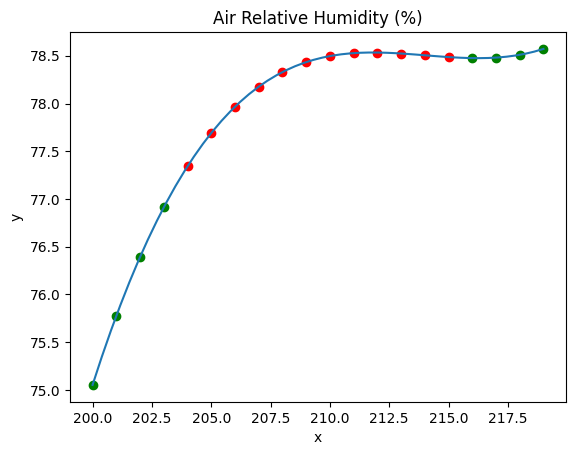

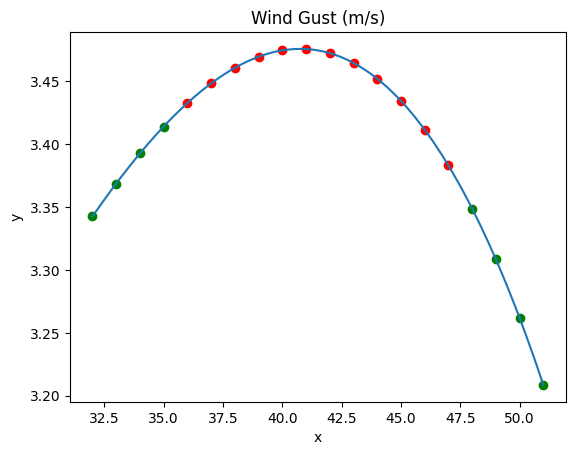

,Ano,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s)
0,2004,1.566832,1004.201705,4778.452944,25.763394,21.331991,77.831477,2.678817
1,2004,1.536759,1004.194676,5650.567150,25.863730,21.290429,77.231127,2.734568
2,2004,1.571170,1004.154226,6503.011823,25.965163,21.274795,76.748211,2.790159
3,2004,1.567157,1004.123674,7090.649623,25.970627,21.293834,76.805728,2.776841
4,2004,1.551923,1004.179262,7596.984170,25.962235,21.291622,76.824245,2.762359
...,...,...,...,...,...,...,...,...
223,2022,1.542199,1004.903465,1483.108115,25.763205,21.274511,78.706121,2.699479
224,2022,1.542535,1004.799872,1485.254390,25.811731,21.309380,78.694507,2.702618
225,2022,1.568829,1004.720131,1483.446729,25.861779,21.371987,78.697160,2.712907
226,2022,1.553015,1004.691465,1476.304721,25.873066,21.399014,78.859708,2.707406


In [8]:
df = read_csv_replace_missing_by_polynomial('alagoas_variacao_climatica.csv', 0, 1)
df.rename(columns={'Date': 'Ano'}, inplace=True)
df['Ano'] = df['Ano'].str[:4].astype(int)
df.drop(columns='State', inplace=True)
df.drop(columns='Year', inplace=True)
df.head(len(df))

In [9]:
df_year = df.copy()
df_year.set_index('Ano', inplace=True)
df_year = df_year.groupby('Ano').mean()
df_year['Precipitation (mm/day)'] = df_year['Precipitation (mm/day)'] * 12
df_year

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s)
Ano,,,,,,,
2004,18.318567,1004.112804,7582.309153,25.954885,21.357492,77.137847,2.805881
2005,18.661286,1004.054525,10037.615252,25.794800,21.359302,77.820404,2.898151
2006,18.650914,1004.814047,8644.693108,26.197017,20.813018,74.006065,3.208877
2007,16.792088,1005.415230,6740.757291,26.500508,20.143018,69.948847,3.448356
2008,19.541805,1004.903885,3228.342662,26.070097,20.787810,74.407297,3.079016
2009,20.736709,1004.528048,1611.970867,25.643630,21.162947,77.670858,2.815837
2010,19.768388,1004.613084,1481.706116,25.439288,21.037877,77.914366,2.782447
2011,18.126355,1004.876381,1381.865715,25.362543,20.922266,77.670210,2.776959
2012,17.184340,1005.022203,1424.662145,25.342566,20.944017,77.821942,2.740248


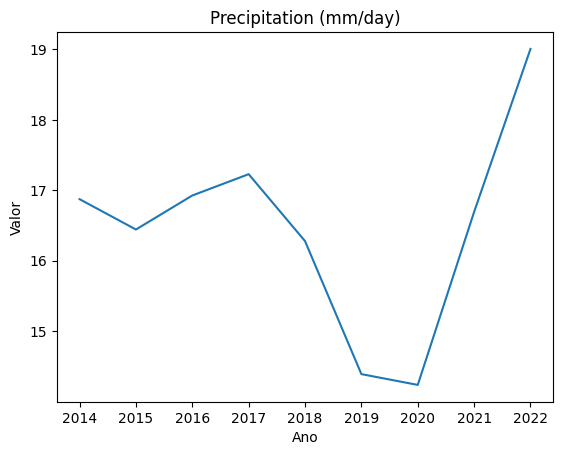

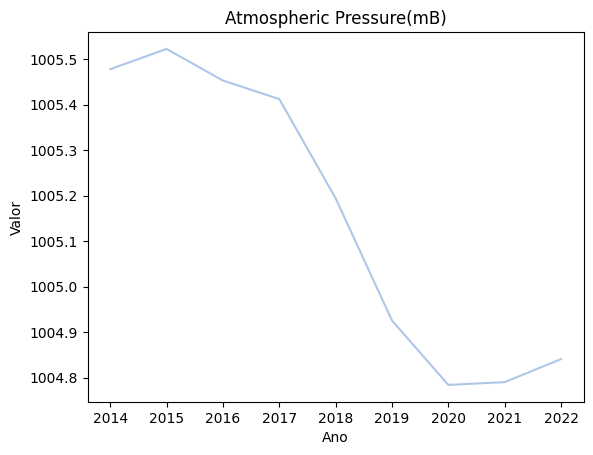

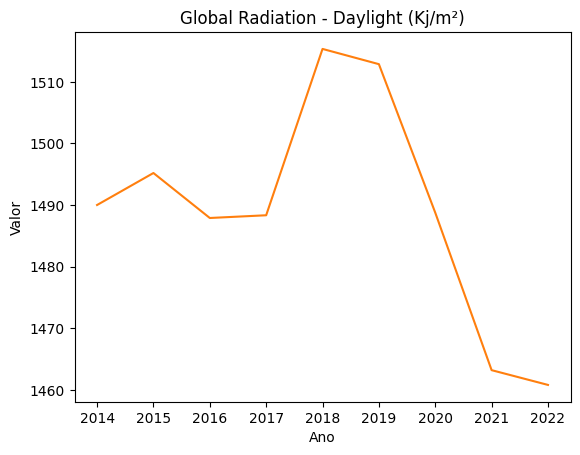

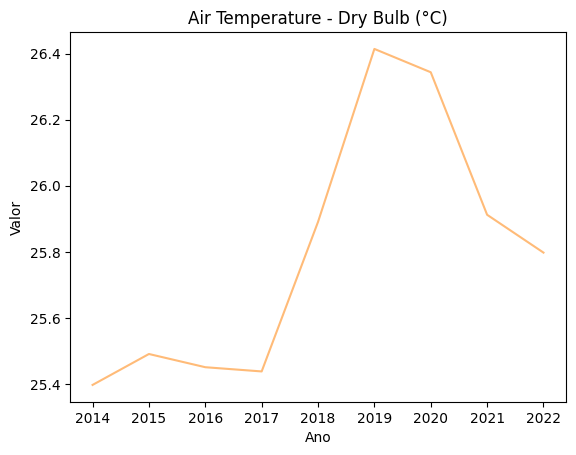

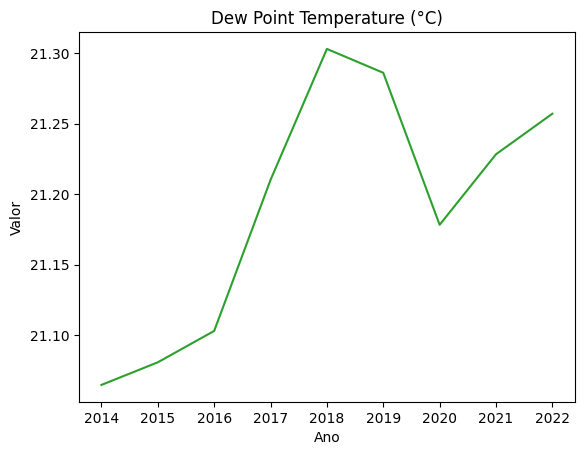

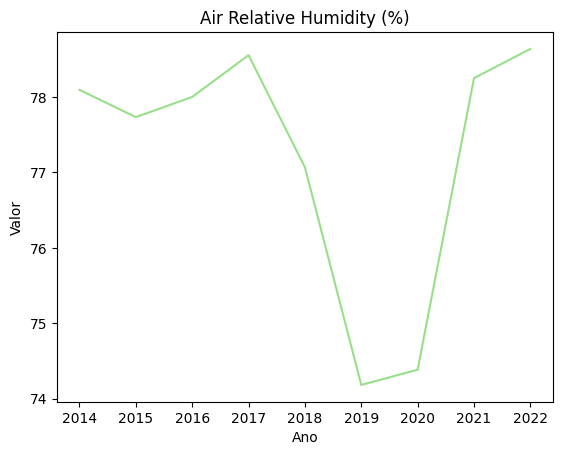

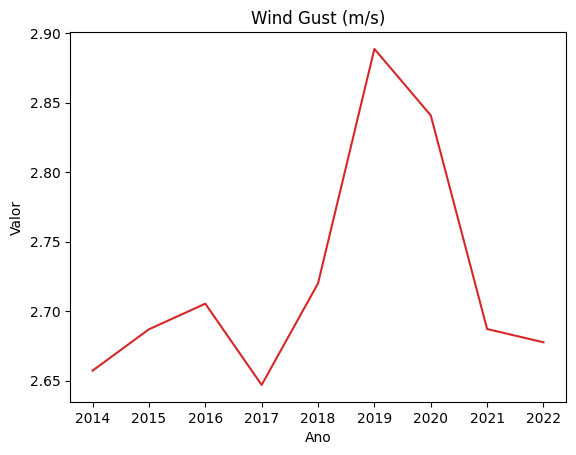

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s)
Ano,,,,,,,
2014,16.874158,1005.478116,1490.005745,25.397446,21.064696,78.095570,2.657262
2015,16.443616,1005.522737,1495.198000,25.490999,21.080729,77.734091,2.687007
2016,16.926315,1005.453192,1487.897624,25.451016,21.102972,78.001380,2.705435
2017,17.228816,1005.412538,1488.339609,25.438238,21.210017,78.555457,2.646980
2018,16.279153,1005.194377,1515.339234,25.890613,21.302886,77.069840,2.720044
2019,14.391737,1004.925660,1512.865070,26.413908,21.285962,74.182188,2.888728
2020,14.238466,1004.784156,1488.758698,26.343333,21.178201,74.384289,2.840934
2021,16.693406,1004.790286,1463.198430,25.912167,21.228201,78.250990,2.687209
2022,19.006079,1004.840962,1460.802556,25.797702,21.256957,78.638550,2.677640


In [10]:
df_2014 = df_year[df_year.index >= 2014]
plot_columns(df_2014)
df_2014

In [11]:
df_2014.to_csv('2014_01_meteo.csv', index=True)

In [12]:
df_2008 = df_year[df_year.index >= 2008]
df_2008

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s)
Ano,,,,,,,
2008,19.541805,1004.903885,3228.342662,26.070097,20.787810,74.407297,3.079016
2009,20.736709,1004.528048,1611.970867,25.643630,21.162947,77.670858,2.815837
2010,19.768388,1004.613084,1481.706116,25.439288,21.037877,77.914366,2.782447
2011,18.126355,1004.876381,1381.865715,25.362543,20.922266,77.670210,2.776959
2012,17.184340,1005.022203,1424.662145,25.342566,20.944017,77.821942,2.740248
2013,17.252127,1005.229473,1469.493466,25.323659,21.009855,78.181963,2.678582
2014,16.874158,1005.478116,1490.005745,25.397446,21.064696,78.095570,2.657262
2015,16.443616,1005.522737,1495.198000,25.490999,21.080729,77.734091,2.687007
2016,16.926315,1005.453192,1487.897624,25.451016,21.102972,78.001380,2.705435


In [13]:
df_2008.to_csv('2008_01_meteo.csv', index=True)